# **CSE655 Homework 3**

* **GTU Artificial Intelligence MSc.**
* **Student Name:** Berkin Barış Yılmaz
* **ID:** 244201001109

## **Part 1: Prediction with LSTM**

In [77]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [254]:
# Extract the data
tsla_dates = []
tsla_open = []
tsla_high = []
tsla_low = []
tsla_close = []
tsla_adj = []
tsla_volume = []

with open("TSLA.csv", "r") as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        tsla_dates.append(row[0])
        tsla_open.append(float(row[1]))
        tsla_high.append(float(row[2]))
        tsla_low.append(float(row[3]))
        tsla_close.append(float(row[4]))
        tsla_adj.append(float(row[5]))
        tsla_volume.append(float(row[6]))

In [255]:
class Data1D:
    def __init__(self, name:str, data:list):
        self.name = name
        self.data = data
        self.max_x = max(data)
        self.min_x = min(data)

    def normalized(self)->list:
        return [(x - self.min_x) / (self.max_x - self.min_x) for x in self.data]

    def denormalize(self, new:list)->list:
        return [x * (self.max_x - self.min_x) + self.min_x for x in new]


In [201]:
tsla = {
    "Open"   : Data1D("Open", tsla_open),
    "Close"  : Data1D("Close", tsla_close),
    "High"   : Data1D("High", tsla_high),
    "Low"    : Data1D("Low", tsla_low),
    "Adj"    : Data1D("Adj", tsla_adj),
    "Volume" : Data1D("Volume", tsla_volume)
}

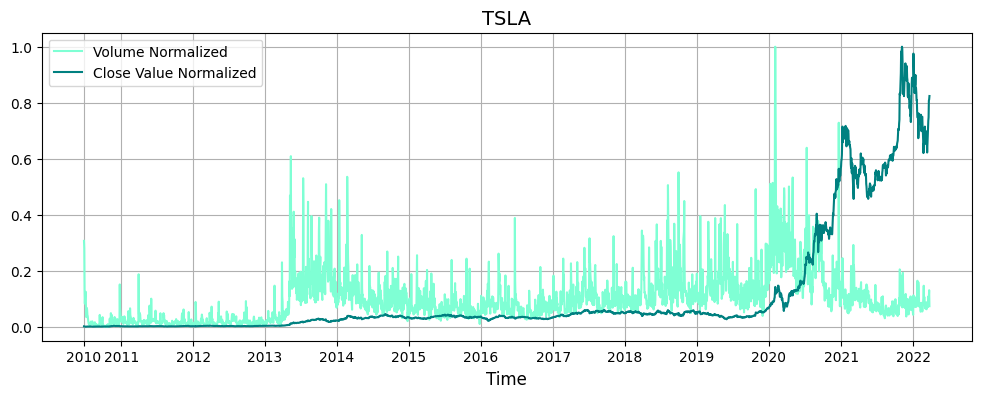

In [202]:
years = [date[:4] for date in tsla_dates] 
unique_years = sorted(set(years))
xticks_positions = [years.index(year) for year in unique_years]

plt.figure(figsize=(12, 4))
plt.plot(tsla["Volume"].normalized(), label="Volume Normalized", color="aquamarine")
plt.plot(tsla["Close"].normalized(), label="Close Value Normalized", color="teal")

plt.title("TSLA", fontsize=14)
plt.xlabel("Time", fontsize=12)

plt.xticks(xticks_positions, unique_years)
plt.legend()
plt.grid(True)
plt.show()

In [82]:
def sequencer(data, interval=10):
    """
    Creates windowed data pieces for training and validation.
    X (Input)  = [i, i+1, i+2 ... interval - 1] 
    Y (Output) = [interval]

    @param data: Time sequenced data set
    @param interval: Window size  
    @return: np.array X, Y 
    """
    X, Y = [], []
    for i in range(len(data) - interval):
        X.append(data[i:i + interval])
        Y.append(data[i + interval])
    return np.array(X), np.array(Y)

In [239]:
interval = 40
data = np.array(tsla["Close"].normalized()).T

X, Y = sequencer(data, interval)

# Training & Validation sets (%70 train, %30 validation)
split_index = int(0.7 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
Y_train, Y_val = Y[:split_index], Y[split_index:]

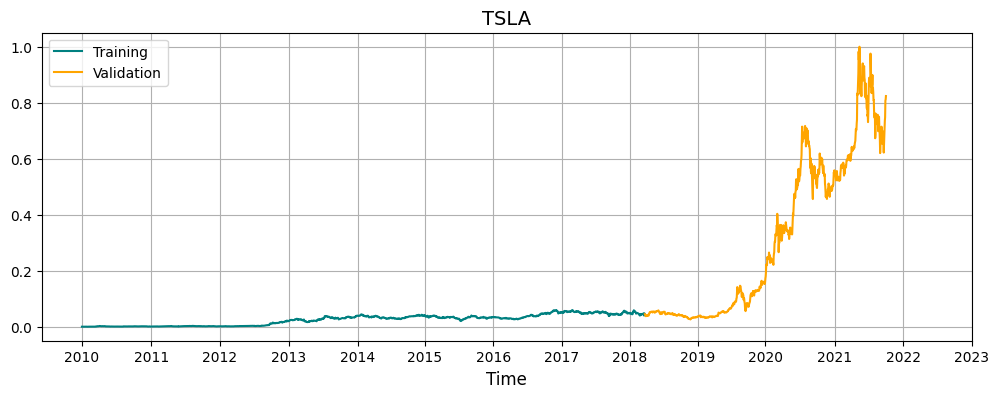

In [238]:
plt.figure(figsize=(12, 4))
plt.plot(range(len(Y_train)), Y_train, label="Training", color="teal")
plt.plot(range(len(Y_train), len(Y_train) + len(Y_val)), Y_val, label="Validation", color="orange")

plt.title("TSLA", fontsize=14)
plt.xlabel("Time", fontsize=12)

plt.xticks(xticks_positions, unique_years)
plt.legend()
plt.grid(True)
plt.show()

In [245]:
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1], 1)),
    layers.LSTM(16),
    layers.Dense(1)
])

In [246]:
# Compile
model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate = 0.001))

# Model Train
history = model.fit(
    X_train, Y_train, 
    validation_data=(X_val, Y_val), 
    epochs=10, 
    batch_size=1,
)


Epoch 1/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 6.5693e-05 - val_loss: 7.2867e-04
Epoch 2/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 5.3706e-06 - val_loss: 5.4374e-04
Epoch 3/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3.6556e-06 - val_loss: 4.0702e-04
Epoch 4/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 2.9227e-06 - val_loss: 3.7886e-04
Epoch 5/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3.0876e-06 - val_loss: 3.3518e-04
Epoch 6/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 2.2799e-06 - val_loss: 3.6780e-04
Epoch 7/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 2.3643e-06 - val_loss: 2.8772e-04
Epoch 8/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 2.5365e-06 - val_loss: 3.9712e-04
Epoch 9/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 2.1873e-06 - val_loss: 5.0051e-04
Epoch 10/10
2041/2041 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.9065e-06 - val_loss: 6.9498e-04


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


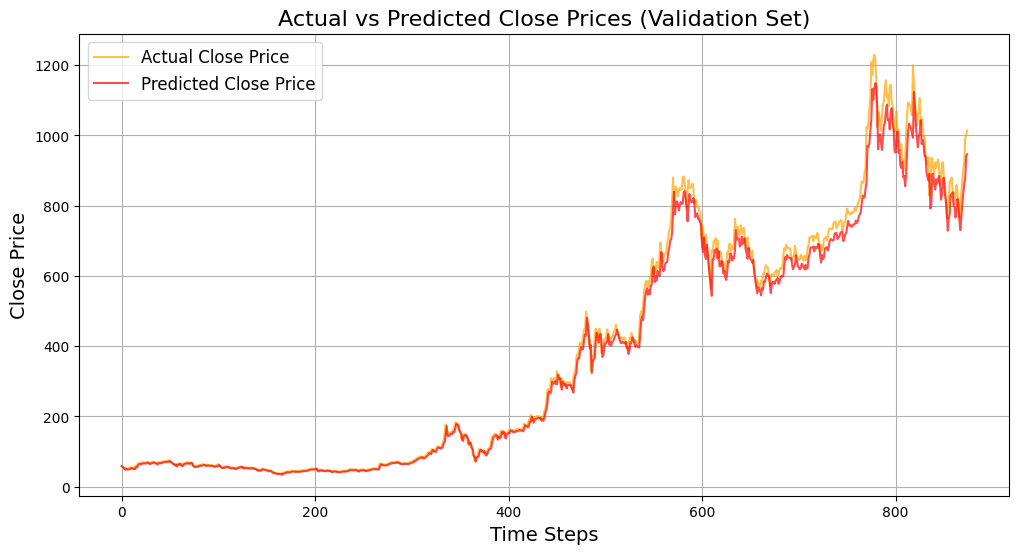

In [247]:
# Predict
predictions = model.predict(X_val)

# Denormalized predictions
denormalized_predictions = Data1D("Close", tsla_close).denormalize(predictions.flatten())
denormalized_actual = Data1D("Close", tsla_close).denormalize(Y_val)

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the denormalized predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(denormalized_actual, label="Actual Close Price", color='orange', alpha=0.7)
plt.plot(denormalized_predictions, label="Predicted Close Price", color='red', alpha=0.7)
plt.title("Actual vs Predicted Close Prices (Validation Set)", fontsize=16)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


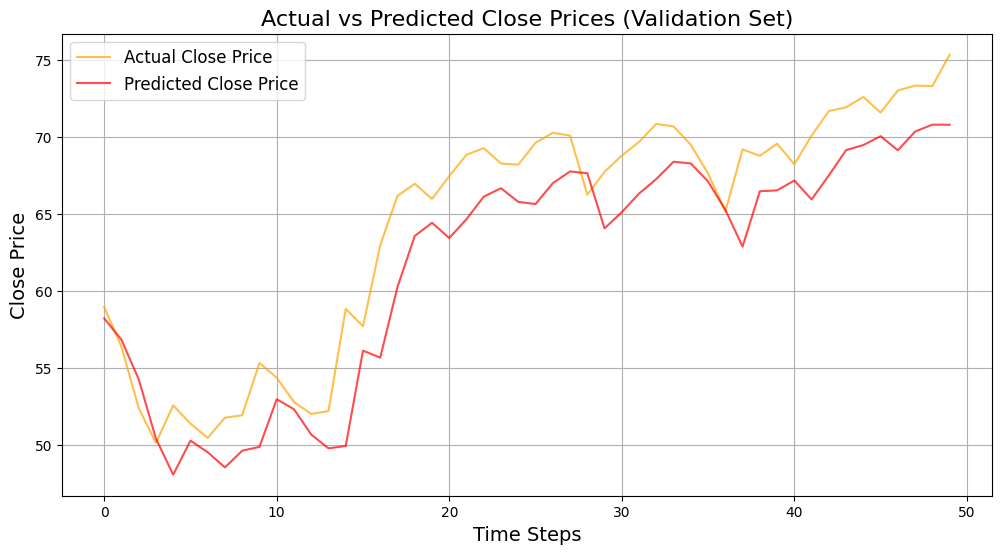

In [ ]:
# Plot the denormalized predictions vs actual values for first 100 days
actual_price = denormalized_actual[:100]
predicted_price = denormalized_predictions[:100]

plt.figure(figsize=(12, 6))
plt.plot(actual_price[:50], label="Actual Close Price", color='orange', alpha=0.7)
plt.plot(predicted_price[:50], label="Predicted Close Price", color='red', alpha=0.7)
plt.title("Actual vs Predicted Close Prices (Validation Set)", fontsize=16)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

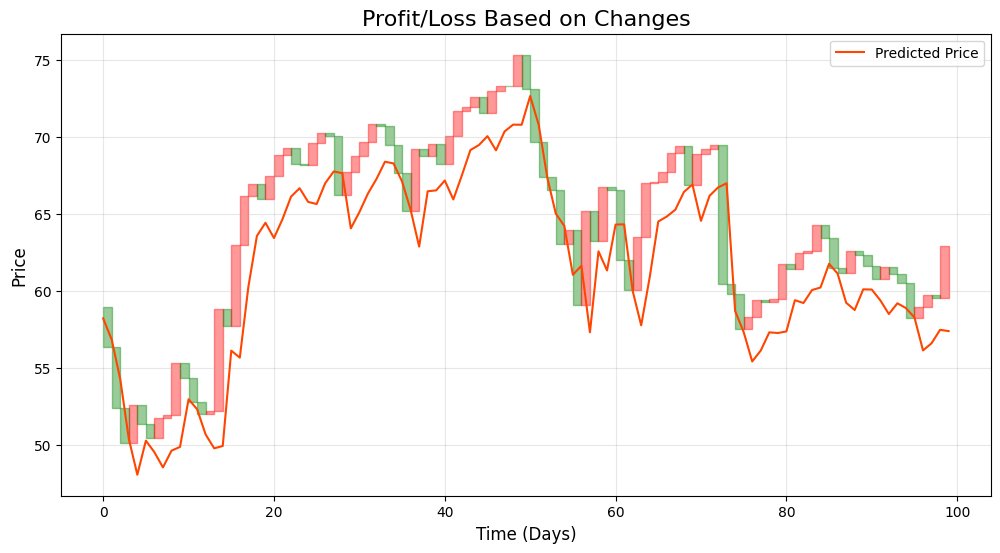

In [249]:

actual_change = np.diff(actual_price)
predicted_change = [predicted_price[i] - actual_price[i - 1] for i in range(1, len(predicted_price))]

plt.figure(figsize=(12, 6))

for i in range(len(actual_change)):
    color = 'green' if np.sign(actual_change[i]) == np.sign(predicted_change[i]) else 'red'
    plt.fill_between([i, i + 1], actual_price[i], actual_price[i + 1], color=color, alpha=0.4)

plt.plot(predicted_price, label="Predicted Price", color="orangered")

plt.title("Profit/Loss Based on Changes", fontsize=16)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

plt.show()

## **Part 1.2 Adding The Gold Prices**

* GOLD.csv Reference : kaggle.com/datasets/sid321axn/gold-price-prediction-dataset

In [253]:
# Extract the data
gold_dates = []
gold_open = []
gold_high = []
gold_low = []
gold_close = []

with open("GOLD.csv", "r") as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        gold_dates.append(row[0])
        gold_open.append(float(row[1]))
        gold_high.append(float(row[2]))
        gold_low.append(float(row[3]))
        gold_close.append(float(row[4]))

print("TSLA", tsla_dates[0], tsla_dates[-1], max(tsla_close))
print("GOLD", gold_dates[0], gold_dates[-1], max(gold_close))



TSLA 2010-06-29 2022-03-24 1229.910034
GOLD 2011-12-15 2018-12-31 173.610001


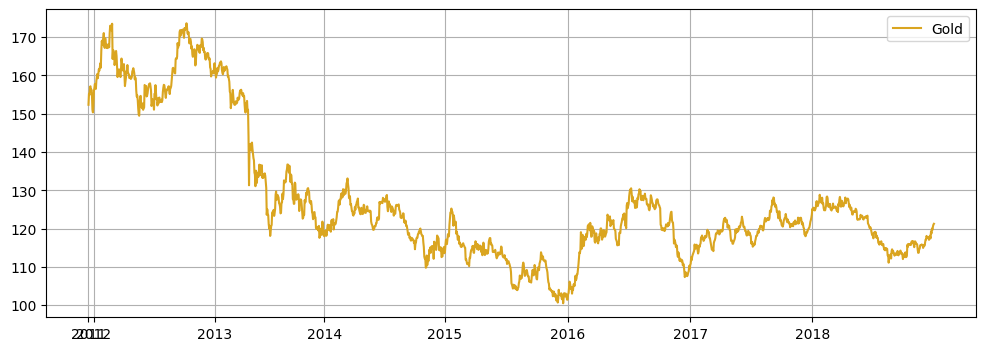

In [259]:

years = [date[:4] for date in gold_dates] 
unique_years = sorted(set(years))
xticks_positions = [years.index(year) for year in unique_years]

plt.figure(figsize=(12, 4))
plt.plot(gold_close, label="Gold", color="goldenrod")

plt.xticks(xticks_positions, unique_years)
plt.legend()
plt.grid(True)
plt.show()